<a href="https://colab.research.google.com/github/Ipsit1234/QML-HEP-Evaluation-Test-GSOC-2021/blob/main/QML_HEP_GSoC_2021_Task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task III: Quantum Convolutional Neural Network (QCNN) Part
Your task is to setup and apply a quantum convolutional neural network (QCNN) on
particle physics data to perform binary classification on two types of objects
(electrons and photons). You should use TFQ for this task.  
The electron-photon dataset (which can be found [here](https://github.com/ML4SCI/ML4SCI_GSoC/tree/main/QMLHEP/qcnn)) contains 100 samples for
training and another 100 for testing, laid out as follows:  
● data["x_train"]: Training dataset of 100 32x32 images containing the particles'
energy (100, 32, 32)  
● data["y_train"]:" Training labels, 0 = "photon", 1 = "electron" (100,)  
● data["x_test"]: Test dataset of 100 32x32 images containing the particles'
energy (100, 32, 32)  
● data["y_test"]:" Test labels, 0 = "photon", 1 = "electron" (100,)  

The dataset labels are labelled 0 for photons and 1 for electrons. Your task is to
implement a QCNN model in Tensorflow Quantum that uses this dataset’s input and
performs binary classification. Please feel free to experiment with different ways of
encoding the classical data inputs into the qubits.  
Specifically, show that the model fits the dataset and that your training loss
decreases over time. (Given the small dataset size, we will not be focusing on the
accuracy of your model).

## Downloading the dataset

In [1]:
!wget https://github.com/ML4SCI/ML4SCI_GSoC/blob/main/QMLHEP/qcnn/electron-photon.npz?raw=true -O electron-photon.npz

--2021-03-19 15:06:37--  https://github.com/ML4SCI/ML4SCI_GSoC/blob/main/QMLHEP/qcnn/electron-photon.npz?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/ML4SCI/ML4SCI_GSoC/raw/main/QMLHEP/qcnn/electron-photon.npz [following]
--2021-03-19 15:06:38--  https://github.com/ML4SCI/ML4SCI_GSoC/raw/main/QMLHEP/qcnn/electron-photon.npz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ML4SCI/ML4SCI_GSoC/main/QMLHEP/qcnn/electron-photon.npz [following]
--2021-03-19 15:06:38--  https://raw.githubusercontent.com/ML4SCI/ML4SCI_GSoC/main/QMLHEP/qcnn/electron-photon.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.co

## Setting up the required libraries

In [2]:
!pip install -q tensorflow==2.3.1
!pip install -q tensorflow-quantum
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

     |████████████████████████████████| 320.4MB 51kB/s 
     |████████████████████████████████| 460kB 20.5MB/s 
     |████████████████████████████████| 20.1MB 102kB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 5.9MB 9.9MB/s 
     |████████████████████████████████| 5.6MB 29.0MB/s 
     |████████████████████████████████| 1.6MB 51.3MB/s 


## Loading the data

In [3]:
with np.load('./electron-photon.npz') as data:
  x_train = data['x_train']
  y_train = data['y_train']
  x_test = data['x_test']
  y_test = data['y_test']

1.0


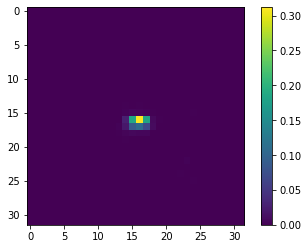

In [4]:
# plot a sample each from the training set
print(y_train[0])

plt.imshow(x_train[0])
plt.colorbar()

## Downscaling the images
An image size of 32x32 is much too large for current quantum computers. We will use PCA to downscale the images to have a feature dimension of 16 i.e., almost 99% reduction in size.

In [5]:
def truncate_x(x_train, x_test, n_components=10):
  """Performs PCA on image dataset keeping the top `n_components` components."""
  n_points_train = tf.gather(tf.shape(x_train), 0)
  n_points_test = tf.gather(tf.shape(x_test), 0)

  # Flatten to 1D
  x_train = tf.reshape(x_train, [n_points_train, -1])
  x_test = tf.reshape(x_test, [n_points_test, -1])

  # Normalize
  feature_mean = tf.reduce_mean(x_train, axis=0)
  x_train_normalized = x_train - feature_mean
  x_test_normalized = x_test - feature_mean

  # Truncate
  eigen_vals, eigen_vectors = tf.linalg.eigh(
      tf.einsum('ji, jk->ik', x_train_normalized, x_train_normalized))
  return tf.einsum('ij, jk->ik', x_train_normalized, eigen_vectors[:, -n_components:]), \
  tf.einsum('ij, jk->ik', x_test_normalized, eigen_vectors[:, -n_components:])

In [6]:
FEATURE_DIM = 16
x_train_small, x_test_small = truncate_x(x_train, x_test, FEATURE_DIM)
print('New Datapoint Dimension:', len(x_train_small[0]))

New Datapoint Dimension: 16


In [7]:
print(y_train[0])

print(x_train_small[0])

1.0
tf.Tensor(
[-1.6053880e-03  2.3733489e-02  1.4729184e-02 -5.9277429e-03
  3.2285508e-05  2.0039830e-02 -5.3670205e-02 -1.6176773e-02
  1.2461127e-02  3.0327177e-02  1.7056542e-02  7.0775233e-02
  3.8512979e-02 -1.3234577e-01  3.6286876e-02 -3.3949080e-01], shape=(16,), dtype=float32)


## Encoding the data as quantum circuits

In [8]:
THRESHOLD = 0

x_train_bin = np.array(x_train_small > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

The qubits at pixel indices with values that exceed a threshold, are rotated through an  $X$  gate.

In [9]:
def convert_to_circuit(image):
  """Encode truncated classical image into quantum datapoint"""
  values = np.ndarray.flatten(image)
  qubits = cirq.GridQubit.rect(1, 16) # LineQubit will give an error when converting to tensors
  circuit = cirq.Circuit()
  for i, value in enumerate(values):
    if value:
      circuit.append(cirq.X(qubits[i]))
  
  return circuit

x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


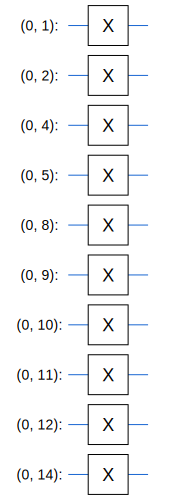

In [10]:
# Visualizing a sample quantum datapoint circuit
SVGCircuit(x_train_circ[0])

In [11]:
# Verifying the encoding
bin_img = x_train_bin[0]
indices = np.array(np.where(bin_img)).T
indices

array([[ 1],
       [ 2],
       [ 4],
       [ 5],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [14]])

## Converting these Cirq circuits into tensors for TFQ

In [12]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

## QCNN Layers

In [13]:
def one_qubit_unitary(bit, symbols):
    """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    """
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])


def two_qubit_unitary(bits, symbols):
    """Make a Cirq circuit that creates an arbitrary two qubit unitary."""
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[6]]
    circuit += [cirq.YY(*bits)**symbols[7]]
    circuit += [cirq.XX(*bits)**symbols[8]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit


def two_qubit_pool(source_qubit, sink_qubit, symbols):
    """Make a Cirq circuit to do a parameterized 'pooling' operation, which
    attempts to reduce entanglement down from two qubits to just one."""
    pool_circuit = cirq.Circuit()
    sink_basis_selector = one_qubit_unitary(sink_qubit, symbols[0:3])
    source_basis_selector = one_qubit_unitary(source_qubit, symbols[3:6])
    pool_circuit.append(sink_basis_selector)
    pool_circuit.append(source_basis_selector)
    pool_circuit.append(cirq.CNOT(control=source_qubit, target=sink_qubit))
    pool_circuit.append(sink_basis_selector**-1)
    return pool_circuit

Printing circuit samples

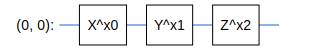

In [14]:
# one qubit unitary
SVGCircuit(one_qubit_unitary(cirq.GridQubit(0, 0), sympy.symbols('x0:3')))

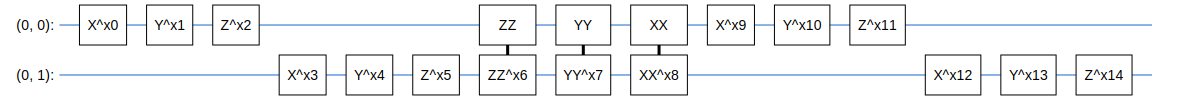

In [15]:
# two qubit unitary
SVGCircuit(two_qubit_unitary(cirq.GridQubit.rect(1, 2), sympy.symbols('x0:15')))

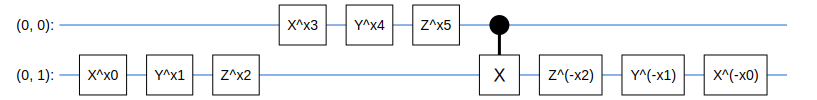

In [16]:
# two qubit pool
SVGCircuit(two_qubit_pool(*cirq.GridQubit.rect(1, 2), sympy.symbols('x0:6')))

### Quantum Convolution
We define the 1D quantum convolution as the application of a two-qubit parameterized unitary to every pair of adjacent qubits with a stride of one.

In [17]:
def quantum_conv_circuit(bits, symbols):
    """Quantum Convolution Layer following the above diagram.
    Return a Cirq circuit with the cascade of `two_qubit_unitary` applied
    to all pairs of qubits in `bits` as in the diagram above.
    """
    circuit = cirq.Circuit()
    for first, second in zip(bits[0::2], bits[1::2]):
        circuit += two_qubit_unitary([first, second], symbols)
    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
        circuit += two_qubit_unitary([first, second], symbols)
    return circuit

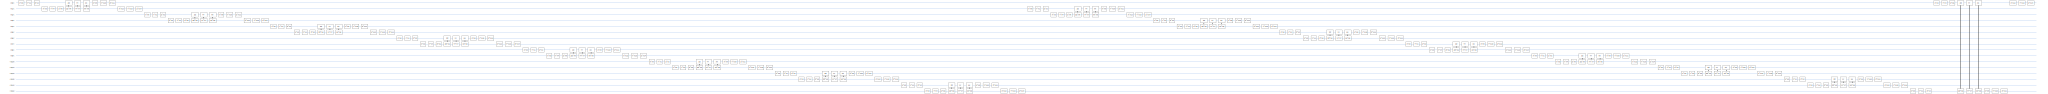

In [18]:
SVGCircuit(
    quantum_conv_circuit(cirq.GridQubit.rect(1, 16), sympy.symbols('x0:15')))

### Quantum pooling
A quantum pooling layer pools from $N$ qubits to $\frac{N}{2}$ qubits using the two-qubit pool defined above.

In [19]:
def quantum_pool_circuit(source_bits, sink_bits, symbols):
  """A layer that specifies a quantum pooling operation.
  A Quantum pool tries to learn to pool the relevant information from two
  qubits to 1.
  """
  circuit = cirq.Circuit()
  for source, sink in zip(source_bits, sink_bits):
    circuit += two_qubit_pool(source, sink, symbols)
  return circuit

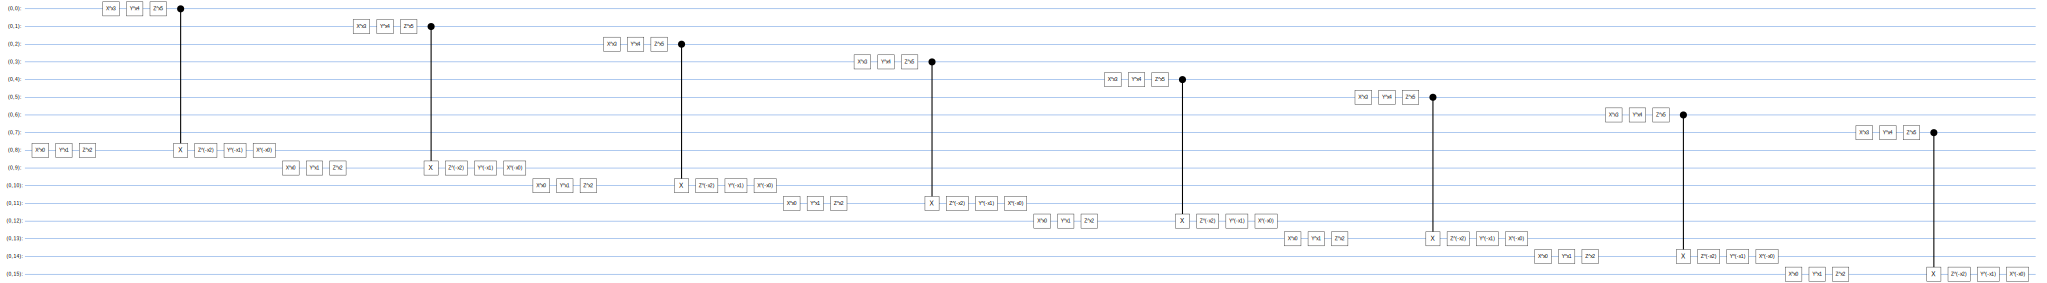

In [20]:
test_bits = cirq.GridQubit.rect(1, 16)
SVGCircuit(quantum_pool_circuit(test_bits[:8], test_bits[8:], sympy.symbols('x0:6')))

## Model Definition

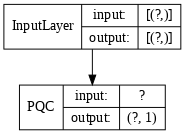

In [21]:
def create_model_circuit(qubits):
    """Create sequence of alternating convolution and pooling operators 
    which gradually shrink over time."""
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols('qconv0:84')
    # Cirq uses sympy.Symbols to map learnable variables. TensorFlow Quantum
    # scans incoming circuits and replaces these with TensorFlow variables.
    model_circuit += quantum_conv_circuit(qubits, symbols[0:15])
    model_circuit += quantum_pool_circuit(qubits[:8], qubits[8:],
                                          symbols[15:21])
    model_circuit += quantum_conv_circuit(qubits[8:], symbols[21:36])
    model_circuit += quantum_pool_circuit(qubits[8:12], qubits[12:],
                                          symbols[36:42])
    model_circuit += quantum_conv_circuit(qubits[12:], symbols[42:57])
    model_circuit += quantum_pool_circuit(qubits[12:14], qubits[14:],
                                          symbols[57:63])
    model_circuit += quantum_conv_circuit(qubits[14:], symbols[63:78])
    model_circuit += quantum_pool_circuit(qubits[14:15], qubits[15:],
                                          symbols[78:84])
    # model_circuit += quantum_conv_circuit(qubits[60:], symbols[84:99])
    # model_circuit += quantum_pool_circuit(qubits[60:62], qubits[62:],
    #                                       symbols[99:105])
    # model_circuit += quantum_conv_circuit(qubits[62:], symbols[105:120])
    # model_circuit += quantum_pool_circuit(qubits[62:63], qubits[63:],
    #                                       symbols[120:126])
    return model_circuit

# Creating qubits and readout operators in Cirq
input_bits = cirq.GridQubit.rect(1, 16)
readout_operators = cirq.Z(input_bits[-1])

input_tensors = tf.keras.Input(shape=(), dtype=tf.string) # since tfq converts Cirq circuits in tf.string dtype
quantum_model = tfq.layers.PQC(create_model_circuit(input_bits), readout_operators)(input_tensors)
qcnn_model = tf.keras.Model(inputs=[input_tensors], outputs=[quantum_model])

# Show the keras plot of the model
tf.keras.utils.plot_model(qcnn_model,
                          show_shapes=True,
                          show_layer_names=False,
                          dpi=70)

## Train the model

In [22]:
@tf.function
def custom_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true)
    y_pred = tf.map_fn(lambda x: 1.0 if x >= 0 else 0.0, y_pred)
    return tf.keras.backend.mean(tf.keras.backend.equal(y_true, y_pred))

qcnn_model.compile(
    loss=tf.losses.mse,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[custom_accuracy])

print(qcnn_model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
pqc (PQC)                    (None, 1)                 84        
Total params: 84
Trainable params: 84
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
EPOCHS = 100

history = qcnn_model.fit(x=x_train_tfcirc,
                         y=y_train,
                         batch_size=16,
                         epochs=EPOCHS,
                         verbose=1,
                         validation_data=(x_test_tfcirc, y_test))

qcnn_results = qcnn_model.evaluate(x_test_tfcirc, y_test)

Epoch 1/100
7/7 [==============================] - 18s 3s/step - loss: 0.5508 - custom_accuracy: 0.4821 - val_loss: 0.4601 - val_custom_accuracy: 0.5982
Epoch 2/100
7/7 [==============================] - 18s 3s/step - loss: 0.5459 - custom_accuracy: 0.5268 - val_loss: 0.4600 - val_custom_accuracy: 0.5536
Epoch 3/100
7/7 [==============================] - 18s 3s/step - loss: 0.5433 - custom_accuracy: 0.5893 - val_loss: 0.4601 - val_custom_accuracy: 0.5536
Epoch 4/100
7/7 [==============================] - 18s 3s/step - loss: 0.5405 - custom_accuracy: 0.6071 - val_loss: 0.4604 - val_custom_accuracy: 0.5268
Epoch 5/100
7/7 [==============================] - 17s 2s/step - loss: 0.5381 - custom_accuracy: 0.6250 - val_loss: 0.4608 - val_custom_accuracy: 0.5179
Epoch 6/100
7/7 [==============================] - 17s 2s/step - loss: 0.5363 - custom_accuracy: 0.6071 - val_loss: 0.4610 - val_custom_accuracy: 0.5268
Epoch 7/100
7/7 [==============================] - 17s 2s/step - loss: 0.5346 - cu

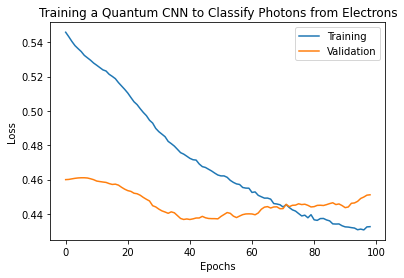

In [24]:
plt.plot(history.history['loss'][1:], label='Training')
plt.plot(history.history['val_loss'][1:], label='Validation')
plt.title('Training a Quantum CNN to Classify Photons from Electrons')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

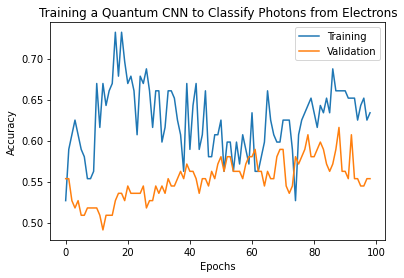

In [25]:
plt.plot(history.history['custom_accuracy'][1:], label='Training')
plt.plot(history.history['val_custom_accuracy'][1:], label='Validation')
plt.title('Training a Quantum CNN to Classify Photons from Electrons')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()